<a href="https://colab.research.google.com/github/maximus-victor/FAU-deep-vision-systems-subm/blob/main/DeepVis_IMAGE_CLASSIFICATION_K-FOLD.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Setup

In [ ]:
config = dict(
    epochs=5,
    batch_size=128,
    learning_rate=0.0001,
    dropout=0,
    fc_layer_size=256,
    optimizer='adam') 

In [ ]:
class EarlyStopping:
    """Early stops the training if validation loss doesn't improve after a given patience."""
    def __init__(self, patience=7, verbose=False, delta=0, path='checkpoint.pt', trace_func=print):
        """
        Args:
            patience (int): How long to wait after last time validation loss improved.
                            Default: 7
            verbose (bool): If True, prints a message for each validation loss improvement. 
                            Default: False
            delta (float): Minimum change in the monitored quantity to qualify as an improvement.
                            Default: 0
            path (str): Path for the checkpoint to be saved to.
                            Default: 'checkpoint.pt'
            trace_func (function): trace print function.
                            Default: print            
        """
        self.patience = patience
        self.verbose = verbose
        self.counter = 0
        self.best_score = None
        self.early_stop = False
        self.val_loss_min = np.Inf
        self.delta = delta
        self.path = path
        self.trace_func = trace_func
    def __call__(self, val_loss, model):

        score = -val_loss

        if self.best_score is None:
            self.best_score = score
            self.save_checkpoint(val_loss, model)
        elif score < self.best_score + self.delta:
            self.counter += 1
            self.trace_func(f'EarlyStopping counter: {self.counter} out of {self.patience}')
            if self.counter >= self.patience:
                self.early_stop = True
        else:
            self.best_score = score
            self.save_checkpoint(val_loss, model)
            self.counter = 0

    def save_checkpoint(self, val_loss, model):
        '''Saves model when validation loss decrease.'''
        if self.verbose:
            self.trace_func(f'Validation loss decreased ({self.val_loss_min:.6f} --> {val_loss:.6f}).  Saving model ...')
        torch.save(model.state_dict(), self.path)
        self.val_loss_min = val_loss

## Libraries & Seed

In [ ]:
import pandas as pd
import numpy as np
import glob
import random
import joblib
import os

from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import matplotlib.patches as patches

from skimage import io

from imutils import paths
from sklearn import preprocessing
from tqdm import tqdm

from sklearn.metrics import confusion_matrix, classification_report
from sklearn.model_selection import StratifiedShuffleSplit

import torch
from torchvision import transforms, datasets
from torchvision.datasets import ImageFolder

import ipywidgets as widgets
from IPython.display import display
import copy

The next block of code applies a seed to our code for reproducibility and also sets the computation device. 

In [ ]:
def seed_libraries(SEED=42):
  # Python seeds
  random.seed(SEED)
  np.random.seed(SEED)
  # Torch seeds
  torch.manual_seed(SEED)
  torch.cuda.manual_seed(SEED)
  torch.cuda.manual_seed_all(SEED)

SEED=42
seed_libraries(SEED=SEED)


# set computation device
runtime = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')
print(f"Computation device: {runtime}")

Computation device: cuda


In [ ]:
username = 'maximus-victor'
repo = 'FAU-deep-vision-systems'

# Max
%cd /content/drive/MyDrive/001_university/001_FAU/002_IIS/DVS
!git config --global user.email "maximilian.harl@gmail.com"
DIR_DATEN = "/content/drive/MyDrive/001_university/001_FAU/002_IIS/DVS/wafer_data/"

%cd {repo}

!git add .

!git commit -m "Retina Net Setup"

/content/drive/MyDrive/001_university/001_FAU/002_IIS/DVS
/content/drive/MyDrive/001_university/001_FAU/002_IIS/DVS/FAU-deep-vision-systems
[main 2fbc61e] Retina Net Setup
 2 files changed, 2 insertions(+), 3496 deletions(-)
 rewrite DeepVis_IMAGE_CLASSIFICATION_K-FOLD.ipynb (98%)
 rewrite DeepVis_Object_Detection.ipynb (61%)


In [ ]:
!git add .

In [ ]:
!git commit -m "MaxNet Fixxed"

[main 6ad6589] MaxNet Fixxed
 1 file changed, 1 insertion(+), 1 deletion(-)
 rewrite DeepVis_IMAGE_CLASSIFICATION_K-FOLD.ipynb (88%)


In [ ]:
!git push

Counting objects: 7, done.
Delta compression using up to 2 threads.
Compressing objects: 100% (7/7), done.
Writing objects: 100% (7/7), 25.01 KiB | 376.00 KiB/s, done.
Total 7 (delta 5), reused 0 (delta 0)
remote: Resolving deltas: 100% (5/5), completed with 2 local objects.
To https://github.com/maximus-victor/FAU-deep-vision-systems
   5c2ac01..6ad6589  main -> main


# **Set Dicitonaries**

**Google Drive Version**

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
# !unzip /content/drive/MyDrive/data.zip

In [ ]:
DIR_DATEN = "/content/drive/MyDrive/DEEPVIS/data"   # make sure to always adapt this to your own folser structure
#DIR_DATEN = "/content/drive/MyDrive/001_university/001_FAU/002_IIS/DVS/wafer_data/" # Max
DIR_DATEN_01 = os.path.join(DIR_DATEN, "01_Daten")
DIR_WAFER_IMAGES = os.path.join(DIR_DATEN, "WaferImages")

## **Load Data**

In [ ]:
labels_filename ="Labels_Waferviertel.xlsx"
meta_filename = "Meta_data.csv"

In [ ]:
labels = pd.read_excel(os.path.join(DIR_DATEN_01, labels_filename))
labels.head(5)

,File Name,Part No,Crack,Patch,Scratch,Low Level,Circle,Displaced,Splinter,Stain,Wafer on Pin,Other,PosX,PosY,Timestamp,PreviousClass,NoOfErrors
0,001932631.tif,0,False,False,False,False,False,False,False,False,False,True,0,0,2019-06-12 13:48:45,other,1
1,001932631.tif,1,False,False,False,False,False,False,False,False,False,True,0,0,2019-06-12 13:48:45,other,1
2,001932631.tif,2,False,False,False,False,False,False,False,False,False,True,0,0,2019-06-12 13:48:45,other,1
3,001932631.tif,3,False,False,False,False,False,False,False,False,False,True,0,0,2019-06-12 13:48:45,other,1
4,001945868.tif,0,False,False,False,False,False,False,False,False,False,True,0,0,2019-06-12 13:48:47,other,1


In [ ]:
labels["PreviousClass"].unique()  # we don't need that any longer?

array(['other', 'patch', 'circle', 'splinter', 'stain', 'waferonpin',
       'crack', 'scratch'], dtype=object)

## **Meta-Data**

In [ ]:
meta = pd.read_csv(os.path.join(DIR_DATEN_01, meta_filename))
meta

,file_name,wafer_id,gray_mean,class,NameBild,SUBSTRATEIDENT,TIMESTAMP_CTS,CTS_EFF,CTS_FF,CTS_VOC,CTS_ISC,CTS_RSER,CTS_RSH,CTS_IREV2_T,CTS_B2B_1,CTS_JOB_NR,CTS_EL_CRACK_COUNT,CTS_EL_DARKAREA_COUNT
0,002152418.tif,2152418,183.47,Cracks,002152418.tif,11790109.0,2018-07-26 14:46:26,23.136937,0.814332,737.587,9.412589,4.987,4481.251483,0.331505,20.010000,20180726 Exp 66,0.0,0.0
1,001889692.tif,1889692,176.80,Cracks,001889692.tif,11232718.0,2018-02-27 13:19:22,23.041940,0.810728,735.176,9.445444,5.032,3471.378009,0.040560,35.639999,20180227 HD556,1.0,0.0
2,001897005.tif,1897005,177.04,Cracks,001897005.tif,11278998.0,2018-03-05 15:07:20,23.073799,0.811632,735.720,9.441592,4.906,3821.416372,0.021333,38.169998,20180305 HD547-4,0.0,0.0
3,001962325.tif,1962325,172.97,Cracks,001962325.tif,11403759.0,2018-04-04 11:41:30,22.571537,0.797088,734.655,9.417174,5.329,3016.940429,0.006562,38.720001,20180328 M2R,1.0,0.0
4,002152288.tif,2152288,173.58,Cracks,002152288.tif,11794609.0,2018-07-26 14:34:30,23.001560,0.810923,735.170,9.428756,5.170,1169.261436,0.182121,20.059999,20180726 Exp 66,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6101,002126113.tif,2126113,213.27,gute_Wafer,002126113.tif,11734418.0,2018-07-02 11:44:45,23.665103,0.821231,744.152,9.462665,4.680,4500.504749,0.009221,43.840000,20180702 EXP41,0.0,0.0
6102,002160320.tif,2160320,172.81,gute_Wafer,002160320.tif,11825342.0,2018-08-02 10:34:09,22.769944,0.800344,734.057,9.471267,5.318,25349.092305,0.000851,19.879999,20180802 EXP 99,0.0,0.0
6103,002161033.tif,2161033,201.44,gute_Wafer,002161033.tif,11827179.0,2018-08-02 11:35:48,23.229798,0.811132,740.253,9.453416,4.889,14218.466321,0.001039,22.299999,20180802 EXP 99,0.0,0.0
6104,002161876.tif,2161876,194.77,gute_Wafer,002161876.tif,11807331.0,2018-08-03 12:47:42,23.060322,0.810989,736.246,9.435790,5.220,2525.808870,0.008307,26.870001,20180803 EXP 58,0.0,0.0


In [ ]:
meta["class"].unique()

array(['Cracks', 'Flecken', 'Kratzer', 'low_level', 'Punkte',
       'schlecht_positioniert', 'Sonstiges', 'Splitter_im_Tester',
       'Verschmutzung', 'Wafer_auf_Pin', 'gute_Wafer'], dtype=object)

## **Load, Select and Encode Images**

In [ ]:
list(paths.list_images(DIR_WAFER_IMAGES))[0].split(os.path.sep)[-2]

'displaced'

In [ ]:
# get all the image paths
image_paths = list(paths.list_images(DIR_WAFER_IMAGES))

# create an empty DataFrame
data = pd.DataFrame()

for i, image_path in tqdm(enumerate(image_paths), total=len(image_paths)):
    data.loc[i, 'label'] = image_path.split(os.path.sep)[-2]  # loading labels into DataFrame based on directory name
    data.loc[i, 'image_path'] = image_path # loading image paths into DataFrame

print(data.head())
print('\n')
print("Unique classes: ", data.label.unique())

100%|██████████| 5944/5944 [00:05<00:00, 1078.18it/s]

       label                                         image_path
0  displaced  /content/drive/MyDrive/DEEPVIS/data/WaferImage...
1  displaced  /content/drive/MyDrive/DEEPVIS/data/WaferImage...
2  displaced  /content/drive/MyDrive/DEEPVIS/data/WaferImage...
3  displaced  /content/drive/MyDrive/DEEPVIS/data/WaferImage...
4  displaced  /content/drive/MyDrive/DEEPVIS/data/WaferImage...


Unique classes:  ['displaced' 'low_level' 'crack' 'patch' 'scratch' 'circle' 'other'
 'splinter' 'stain' 'waferonpin' 'good']


In [ ]:
sel_classes = ['circle', 'crack', 'good', 'scratch', 'splinter', 'stain'] # selecting bounding boxes classes

data = data[data['label'].isin(sel_classes)] # reducing DataFrame to the selected classes
data.label.unique()

lb = preprocessing.LabelEncoder() # encoding target labels with values between 0 and n_classes-1
data['label'] = lb.fit_transform(data['label']) #  appling encoded labels to our DataFrame data

print(data.head())

      label                                         image_path
1413      1  /content/drive/MyDrive/DEEPVIS/data/WaferImage...
1414      1  /content/drive/MyDrive/DEEPVIS/data/WaferImage...
1415      1  /content/drive/MyDrive/DEEPVIS/data/WaferImage...
1416      1  /content/drive/MyDrive/DEEPVIS/data/WaferImage...
1417      1  /content/drive/MyDrive/DEEPVIS/data/WaferImage...


In [ ]:
len(lb.classes_)

6

In [ ]:
mapping = dict(zip(lb.classes_, lb.transform(lb.classes_)))
inverse_mapping = dict(zip(lb.transform(lb.classes_), lb.classes_))

print("Mapping label to class:")
print('\n')
print(inverse_mapping)

Mapping label to class:


{0: 'circle', 1: 'crack', 2: 'good', 3: 'scratch', 4: 'splinter', 5: 'stain'}


<BarContainer object of 6 artists>

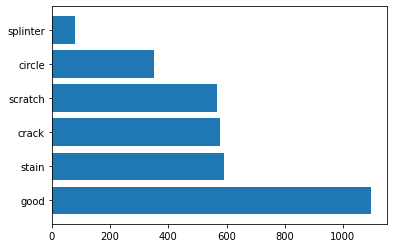

In [ ]:
values = data.label.value_counts() # plotting the number of occurrences of each label
classes = [inverse_mapping[i] for i in values.index]
plt.barh(classes, values)

# Add the data value on head of the bar
#for value in plot:
#    height = value.get_height()
#    plt.text(value.get_x() + value.get_width()/2.,
#             1.002*height,'%d' % int(height), ha='center', va='bottom')

# Prepare Dataset into Train and Val and and Test (60:20:20)



In [ ]:
X = data.image_path
y = data.label

n_splits = 1  # A single split in this case
sss_test = StratifiedShuffleSplit(n_splits=n_splits, test_size=0.20, random_state=42) 

for train_val_index, test_index in sss_test.split(X, y):
  X_train_val, X_test = X.iloc[train_val_index], X.iloc[test_index]
  y_train_val, y_test = y.iloc[train_val_index], y.iloc[test_index]

from sklearn.model_selection import StratifiedKFold

k_folds_splits = 5

skf = StratifiedKFold(n_splits=k_folds_splits, random_state=42)
#skf.get_n_splits(X_train_val, y_train_val)

print(skf)

k_folds_train = {}
k_folds_val = {}

y_train_val_iter = y_train_val.copy()

i = 1
for train_index, val_index in skf.split(X_train_val, y_train_val_iter.astype('int')):
  # print("TRAIN:", train_index, "Val:", val_index)
  X_train, X_val = X_train_val.iloc[train_index], X_train_val.iloc[val_index]
  y_train, y_val = y_train_val.iloc[train_index], y_train_val.iloc[val_index]
  k_folds_train[f'{i}-fold'] = [X_train, y_train]
  k_folds_val[f'{i}-fold'] = [X_val, y_val]
  i += 1

StratifiedKFold(n_splits=5, random_state=42, shuffle=False)


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_split.py:296: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  FutureWarning


In [ ]:
print(len(X), len(y))

3264 3264


In [ ]:
for k in range(k_folds_splits):
  print(f'Train {k+1}-k-fold - Values', len(list(k_folds_train.values())[k][0]))
  print(f'Train {k+1}-k-fold - Labels', len(list(k_folds_train.values())[k][1]))
  print(f'Val {k+1}-k-fold - Values', len(list(k_folds_val.values())[k][0]))
  print(f'Val {k+1}-k-fold - Labels', len(list(k_folds_val.values())[k][1]))
  print('\n')

Train 1-k-fold - Values 2088
Train 1-k-fold - Labels 2088
Val 1-k-fold - Values 523
Val 1-k-fold - Labels 523


Train 2-k-fold - Values 2089
Train 2-k-fold - Labels 2089
Val 2-k-fold - Values 522
Val 2-k-fold - Labels 522


Train 3-k-fold - Values 2089
Train 3-k-fold - Labels 2089
Val 3-k-fold - Values 522
Val 3-k-fold - Labels 522


Train 4-k-fold - Values 2089
Train 4-k-fold - Labels 2089
Val 4-k-fold - Values 522
Val 4-k-fold - Labels 522


Train 5-k-fold - Values 2089
Train 5-k-fold - Labels 2089
Val 5-k-fold - Values 522
Val 5-k-fold - Labels 522




Sanity Check

In [ ]:
# check if split correct
print(len(X_train))
print(len(y_train))
print(len(X_val))
print(len(y_val))
print(len(X_test))
print(len(y_test))

2089
2089
522
522
653
653


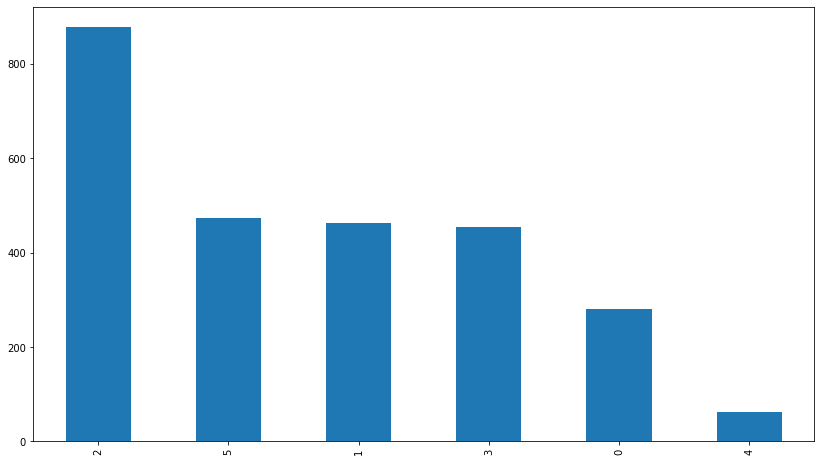

In [ ]:
y_train_val.value_counts().plot(kind='bar', figsize=(14, 8)) # plotting the number of occurrences of each label

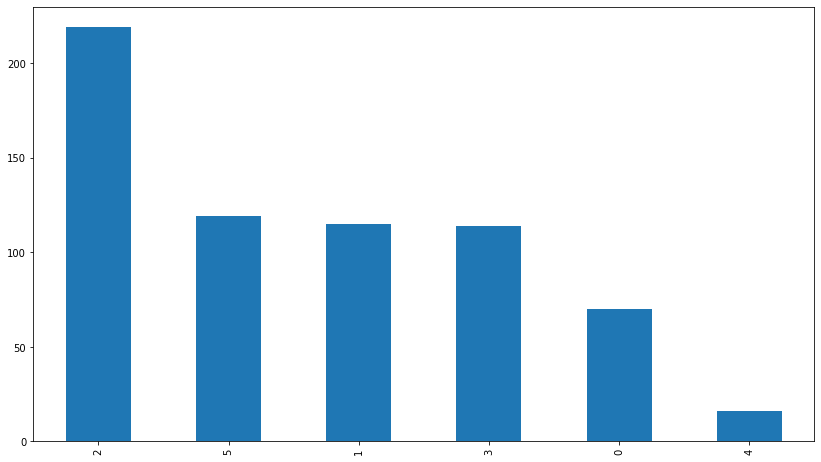

In [ ]:
y_test.value_counts().plot(kind='bar', figsize=(14, 8)) # plotting the number of occurrences of each label

# Data Loaders

In [ ]:
from torch.utils.data import Dataset, DataLoader
from PIL import Image

In [ ]:
def load_image(infilename, infilegrayscale):
    """
    This function loads an image into memory when you give it the path of the image
    """
    if infilegrayscale:
      img = Image.open(infilename).convert('L')
    else:
      img = Image.open(infilename)
    #data = np.asarray(img)
    return img

In [ ]:
class WaferDataset(Dataset):
    def __init__(self, path, labels, model=None):
        self.X = path
        self.y = labels
        self.model = model
        if self.model in ["BaseNet", "RegNet", "VicNet"]:
          self.infilegrayscale = True
        else:
          self.infilegrayscale = False

        # preprocessing
        if model in ["ResNet18", "VGG16"]: # validation
            self.preprocess = transforms.Compose([
              transforms.Resize(244),
              transforms.CenterCrop(224),
              transforms.ToTensor(),
              transforms.Lambda(lambda x: x.repeat(3, 1, 1)),  # duplicate channel as Resnet18 based on RGB
              transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
              # Data augmentation
              transforms.RandomHorizontalFlip(p=0.5),
              transforms.RandomRotation(30),
              transforms.RandomVerticalFlip(p=0.5)
            ])
        elif model in ["BaseNet", "RegNet", "VicNet", "MaxNet"]:
          self.preprocess = transforms.Compose([
              transforms.Resize(244),
              transforms.CenterCrop(224),
              transforms.ToTensor(),
              # Data augmentation
              transforms.RandomHorizontalFlip(p=0.5),
              transforms.RandomRotation(30),
              transforms.RandomVerticalFlip(p=0.5)
            ])
        
    def __len__(self):
        return (len(self.X))
    
    def __getitem__(self, i):
        image = load_image(self.X.iloc[i], self.infilegrayscale)
        label = self.y.iloc[i]
        if self.model is not None:
          image = self.preprocess(image)
        # print(image.shape)
        return torch.tensor(image, dtype=torch.float), torch.tensor(label, dtype=torch.long)

# Models

## Unregularized Model

In [ ]:
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import matplotlib.pyplot as plt

In [ ]:
from torchvision import models

In [ ]:
class BaseNet(nn.Module):
  def __init__(self, input_shape=(1, 224, 224)):
    super().__init__()
    # Here, we define all the weights for the neural network, they are abstracted by layers. Internally however, they are represented by Pytorch tensors.
    self.conv1 = nn.Conv2d(in_channels=1, out_channels=32, kernel_size=3)
    self.conv2 = nn.Conv2d(in_channels=32, out_channels=64, kernel_size=3)
    self.conv3 = nn.Conv2d(in_channels=64, out_channels=128, kernel_size=3)

    self.pool = nn.MaxPool2d(kernel_size=2)

    n_size = self._get_conv_output(input_shape)

    self.fc1 = nn.Linear(in_features=n_size, out_features=config['fc_layer_size'])
    self.fc2 = nn.Linear(in_features=config['fc_layer_size'], out_features=len(lb.classes_))

  def _get_conv_output(self, shape):
    batch_size = 1
    input = torch.autograd.Variable(torch.rand(batch_size, *shape))
    output_feat = self._forward_features(input)
    n_size = output_feat.data.view(batch_size, -1).size(1)
    return n_size
  
  def _forward_features(self, x):
    x = self.pool(F.relu(self.conv1(x)))
    x = self.pool(F.relu(self.conv2(x)))
    x = self.pool(F.relu(self.conv3(x)))
    return x
  
  def forward(self, x):
      # Here, we define how an input x is translated into an output. In our linear example, this was simply (x^T * w), now it becomes more complex but
      # we don't have to care about that (gradients etc. are taken care of by Pytorch).
      x = self._forward_features(x)
      # You can always print shapes and tensors here. This is very very helpful to debug.
      # print("x.shape:", x.shape)
      x = x.view(x.size(0), -1)
      x = F.relu(self.fc1(x))
      x = self.fc2(x)
      return x

In [ ]:
basenet = BaseNet()
basenet = basenet.to(runtime)

print(basenet)

/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:718: UserWarning: Named tensors and all their associated APIs are an experimental feature and subject to change. Please do not use them for anything important until they are released as stable. (Triggered internally at  /pytorch/c10/core/TensorImpl.h:1156.)
  return torch.max_pool2d(input, kernel_size, stride, padding, dilation, ceil_mode)


BaseNet(
  (conv1): Conv2d(1, 32, kernel_size=(3, 3), stride=(1, 1))
  (conv2): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1))
  (conv3): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1))
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (fc1): Linear(in_features=86528, out_features=256, bias=True)
  (fc2): Linear(in_features=256, out_features=6, bias=True)
)


## Regularized Model

In [ ]:
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import matplotlib.pyplot as plt

In [ ]:
class RegNet(nn.Module):
  def __init__(self, input_shape=(1, 224, 224)):
    super().__init__()
    # Here, we define all the weights for the neural network, they are abstracted by layers. Internally however, they are represented by Pytorch tensors.
    self.conv1 = nn.Conv2d(in_channels=1, out_channels=32, kernel_size=3)
    self.batchnorm1 = nn.BatchNorm2d(32)
    self.conv2 = nn.Conv2d(in_channels=32, out_channels=64, kernel_size=3)
    self.batchnorm2 = nn.BatchNorm2d(64)
    self.conv3 = nn.Conv2d(in_channels=64, out_channels=128, kernel_size=3)
    self.batchnorm3 = nn.BatchNorm2d(128)

    self.pool = nn.MaxPool2d(kernel_size=2)

    n_size = self._get_conv_output(input_shape)

    self.fc1 = nn.Linear(in_features=n_size, out_features=config['fc_layer_size'])
    self.fc2 = nn.Linear(in_features=config['fc_layer_size'], out_features=len(lb.classes_))

    self.dropout = nn.Dropout(config['dropout'])

  def _get_conv_output(self, shape):
    batch_size = 1
    input = torch.autograd.Variable(torch.rand(batch_size, *shape))
    output_feat = self._forward_features(input)
    n_size = output_feat.data.view(batch_size, -1).size(1)
    return n_size
  
  def _forward_features(self, x):
    x = self.pool(F.relu(self.conv1(x)))
    x = self.pool(F.relu(self.conv2(x)))
    x = self.pool(F.relu(self.conv3(x)))
    return x
  
  def forward(self, x):
      # Here, we define how an input x is translated into an output. In our linear example, this was simply (x^T * w), now it becomes more complex but
      # we don't have to care about that (gradients etc. are taken care of by Pytorch).
      x = self._forward_features(x)
      # You can always print shapes and tensors here. This is very very helpful to debug.
      # print("x.shape:", x.shape)
      x = x.view(x.size(0), -1)
      x = F.relu(self.fc1(x))
      x = self.dropout(x)
      x = self.fc2(x)
      return x

In [ ]:
regnet = RegNet()
regnet = regnet.to(runtime)

print(regnet)

RegNet(
  (conv1): Conv2d(1, 32, kernel_size=(3, 3), stride=(1, 1))
  (batchnorm1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv2): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1))
  (batchnorm2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv3): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1))
  (batchnorm3): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (fc1): Linear(in_features=86528, out_features=256, bias=True)
  (fc2): Linear(in_features=256, out_features=6, bias=True)
  (dropout): Dropout(p=0, inplace=False)
)


## VicNet

In [ ]:
class resBlock(nn.Module):
    def __init__(self, in_channels, out_channels, kernel_size=3, stride=1):
      super().__init__()
      self.in_channels = in_channels
      self.out_channels = out_channels
      self.kernel_size = kernel_size
      self.stride = stride
      self.downsample = None

      if stride != 1 or in_channels != out_channels:
        self.downsample = nn.Sequential(nn.Conv2d(self.in_channels, self.out_channels, 1, self.stride),
                                        nn.BatchNorm2d(self.out_channels))

      self.block = nn.Sequential(nn.Conv2d(self.in_channels, self.out_channels, self.kernel_size, self.stride, padding=1),
                                nn.BatchNorm2d(self.out_channels),
                                nn.ReLU(),
                                nn.Conv2d(self.out_channels, self.out_channels, self.kernel_size, 1, padding=1),
                                nn.BatchNorm2d(self.out_channels))
      self.relu = nn.ReLU()

                               
    def forward(self, x):
      skip = x
      x = self.block(x)
      if self.downsample is not None:
        skip = self.downsample(skip)
      x += skip
      x = self.relu(x)
      return x

In [ ]:
class VicNet(nn.Module):
  def __init__(self, input_shape=(1, 224, 224)):
    super().__init__()
    self.conv1 = nn.Conv2d(in_channels=1, out_channels=16, kernel_size=3)
    self.conv2 = nn.Conv2d(in_channels=16, out_channels=32, kernel_size=3)
    self.max_pool = nn.MaxPool2d(kernel_size=2)
    self.dropout = nn.Dropout2d(config['dropout'])
    self.block1 = resBlock(in_channels=32, out_channels=32)
    self.block2 = resBlock(in_channels=32, out_channels=64, stride=2)
    self.block3 = resBlock(in_channels=64, out_channels=128, stride=2)
    self.block4 = resBlock(in_channels=128, out_channels=256)
    self.avg_pool = nn.AvgPool2d(kernel_size=2)

    n_size = self._get_conv_output(input_shape)

    self.fc1 = nn.Linear(in_features=n_size, out_features=config['fc_layer_size'])
    self.fc2 = nn.Linear(in_features=config['fc_layer_size'], out_features=len(sel_classes))

  def _get_conv_output(self, shape):
    batch_size = 1
    input = torch.autograd.Variable(torch.rand(batch_size, *shape))
    output_feat = self._forward_features(input)
    n_size = output_feat.data.view(batch_size, -1).size(1)
    return n_size
  
  def _forward_features(self, x):
    x = self.max_pool(F.relu(self.conv1(x)))
    x = self.max_pool(F.relu(self.conv2(x)))
    x = self.block1(x)
    x = self.block2(x)
    x = self.block3(x)
    x = self.block4(x)
    x = self.avg_pool(x)
    return x

  def forward(self, x):
    x = self._forward_features(x)
    x = torch.flatten(x, 1)
    x = F.relu(self.fc1(x))
    x = self.fc2(x)
    return x

In [ ]:
vicnet = VicNet()
vicnet = vicnet.to(runtime)

print(vicnet)

VicNet(
  (conv1): Conv2d(1, 16, kernel_size=(3, 3), stride=(1, 1))
  (conv2): Conv2d(16, 32, kernel_size=(3, 3), stride=(1, 1))
  (max_pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (dropout): Dropout2d(p=0, inplace=False)
  (block1): resBlock(
    (block): Sequential(
      (0): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU()
      (3): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (4): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (relu): ReLU()
  )
  (block2): resBlock(
    (downsample): Sequential(
      (0): Conv2d(32, 64, kernel_size=(1, 1), stride=(2, 2))
      (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (block): Sequential(
      (0): Conv2d(32, 64, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1

## MaxNet

In [ ]:
class Flatten(nn.Module):
    def forward(self, input):
        return input.view(input.size(0), -1)


class ConnectionBlock(nn.Module):
    def __init__(self, in_c, out_c, stride):
        super().__init__()

        self.pathA = nn.Sequential(
            nn.Conv2d(
                in_channels=in_c,
                out_channels=out_c,
                kernel_size=3,
                stride=stride,
                padding=1),
            nn.Dropout2d(config['dropout']),
            nn.BatchNorm2d(num_features=out_c),
            nn.ReLU(),
            nn.Conv2d(
                in_channels=out_c,
                out_channels=out_c,
                kernel_size=3,
                stride=1,
                padding=1),
            nn.Dropout2d(config['dropout']),
            nn.BatchNorm2d(num_features=out_c),
            nn.ReLU())

        self.pathB = nn.Sequential(
            nn.Conv2d(
                in_channels=in_c,
                out_channels=out_c,
                kernel_size=5,
                stride=stride,
                padding=2),
            nn.Dropout2d(config['dropout']),
            nn.BatchNorm2d(num_features=out_c),
            nn.ReLU(),
            nn.Conv2d(
                in_channels=out_c,
                out_channels=out_c,
                kernel_size=5,
                stride=1,
                padding=2),
            nn.Dropout2d(config['dropout']),
            nn.BatchNorm2d(num_features=out_c),
            nn.ReLU())

        self.pathC = nn.Sequential(
            nn.Conv2d(
                in_channels=in_c,
                out_channels=out_c,
                kernel_size=9,
                stride=stride,
                padding=4),
            nn.Dropout2d(config['dropout']),
            nn.BatchNorm2d(num_features=out_c),
            nn.ReLU(),
            nn.Conv2d(
                in_channels=out_c,
                out_channels=out_c,
                kernel_size=9,
                stride=1,
                padding=4),
            nn.Dropout2d(config['dropout']),
            nn.BatchNorm2d(num_features=out_c),
            nn.ReLU())

        self.pathSkip = nn.Sequential(
            nn.Conv2d(
                in_channels=in_c,
                out_channels=out_c,
                kernel_size=1,
                stride=stride),
            nn.Dropout2d(config['dropout']),
            nn.BatchNorm2d(num_features=out_c))

    def forward(self, x):
        return self.pathA(x) + self.pathB(x) + self.pathC(x) + self.pathSkip(x)


class MaxNet(nn.Module):
    def __init__(self, out_classes=len(lb.classes_), input_shape=(1, 224, 224)):
        super().__init__()
        self.net = nn.Sequential(
            nn.Conv2d(in_channels=1, out_channels=64, kernel_size=7, stride=2),
            nn.BatchNorm2d(num_features=64),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=3, stride=2),
            ConnectionBlock(in_c=64, out_c=64, stride=1),
            ConnectionBlock(in_c=64, out_c=128, stride=2),
            ConnectionBlock(in_c=128, out_c=256, stride=2),
            ConnectionBlock(in_c=256, out_c=512, stride=2),
            nn.AvgPool2d(kernel_size=(2, 2)),
            Flatten(),
            nn.Linear(in_features=4608, out_features=config['fc_layer_size']),
            nn.ReLU(),
            nn.Dropout(config['dropout']),
            nn.Linear(in_features=config['fc_layer_size'], out_features=config['fc_layer_size']),
            nn.ReLU(),
            nn.Linear(in_features=config['fc_layer_size'], out_features=out_classes),
            #nn.Sigmoid()
            )

    def forward(self, x):
      return self.net(x)

In [ ]:
maxnet = MaxNet()
maxnet = maxnet.to(runtime)

print(maxnet)

MaxNet(
  (net): Sequential(
    (0): Conv2d(1, 64, kernel_size=(7, 7), stride=(2, 2))
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    (4): ConnectionBlock(
      (pathA): Sequential(
        (0): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
        (1): Dropout2d(p=0, inplace=False)
        (2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (3): ReLU()
        (4): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
        (5): Dropout2d(p=0, inplace=False)
        (6): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (7): ReLU()
      )
      (pathB): Sequential(
        (0): Conv2d(64, 64, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
        (1): Dropout2d(p=0, inplace=False)
        (2): BatchNorm2d(64, eps=1e-05, mome

## ResNet

In [ ]:
from torchvision import models

In [ ]:
resnet18 = models.resnet18(pretrained=True)  
for param in resnet18.parameters():
  param.requires_grad=False # freezes the layers to only fine-tune the last one

print(resnet18)

Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to /root/.cache/torch/hub/checkpoints/resnet18-f37072fd.pth


  0%|          | 0.00/44.7M [00:00<?, ?B/s]

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

## VGG

Also try VGG16 without batch norm

In [ ]:
vgg16 = models.vgg16_bn(pretrained=True)
for param in vgg16.features.parameters():
  param.requires_grad=False # freezes the layers to only fine-tune the last one

print(vgg16)

Downloading: "https://download.pytorch.org/models/vgg16_bn-6c64b313.pth" to /root/.cache/torch/hub/checkpoints/vgg16_bn-6c64b313.pth


  0%|          | 0.00/528M [00:00<?, ?B/s]

VGG(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (4): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): ReLU(inplace=True)
    (6): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (7): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (9): ReLU(inplace=True)
    (10): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (12): ReLU(inplace=True)
    (13): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (14): Conv2d(128, 256

# Model Selection

In [ ]:
list_transfer_model = ['ResNet18', 'VGG16']

w = widgets.Dropdown(options={'VicNet': vicnet,
                              'ResNet18': resnet18, 
                              'VGG16': vgg16, 
                              'RegNet': regnet, 
                              'BaseNet': basenet, 
                              'MaxNet': maxnet})
display(w)

Dropdown(options={'VicNet': VicNet(
  (conv1): Conv2d(1, 16, kernel_size=(3, 3), stride=(1, 1))
  (conv2): Con…

In [ ]:
print(f'Selected Net: {w.label}')
w.value

Selected Net: VGG16


VGG(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (4): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): ReLU(inplace=True)
    (6): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (7): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (9): ReLU(inplace=True)
    (10): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (12): ReLU(inplace=True)
    (13): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (14): Conv2d(128, 256

In [ ]:
net = w.value

# Training

To measuse inference time: https://towardsdatascience.com/the-correct-way-to-measure-inference-time-of-deep-neural-networks-304a54e5187f

In [ ]:
def reset_weights(m):
  '''
    Try resetting model weights to avoid
    weight leakage.
  '''
  for layer in m.children():
   if hasattr(layer, 'reset_parameters'):
    print(f'Reset trainable parameters of layer = {layer}')
    layer.reset_parameters()

In [ ]:
%%time
early_stopping_patience = 10
epochs = config['epochs']
if w.label in list_transfer_model:
  transferlearning = True
else:
  transferlearning = False

min_val_loss = np.Inf

kf_train_losses = []
kf_val_losses = []
kf_train_acc = []
kf_val_acc = []
kf_class_accuracy = []
kf_overall_accuracy = []
kf_overall_precision = []
kf_overall_recall = []
kf_overall_f1 = []
kf_class_precision = []
kf_class_recall = []
kf_class_f1 = []
kf_timings = []
kf_frames = []


for k in range(k_folds_splits):

  # initialize the early_stopping object
  early_stopping = EarlyStopping(patience=early_stopping_patience, verbose=True)

  print(f'Train {k+1}-k-fold - Values', len(list(k_folds_train.values())[k][0]))
  print(f'Train {k+1}-k-fold - Labels', len(list(k_folds_train.values())[k][1]))
  print(f'Val {k+1}-k-fold - Values', len(list(k_folds_val.values())[k][0]))
  print(f'Val {k+1}-k-fold - Labels', len(list(k_folds_val.values())[k][1]))
  print('\n')

  X_train = list(k_folds_train.values())[k][0]
  y_train = list(k_folds_train.values())[k][1]
  X_val = list(k_folds_val.values())[k][0]
  y_val = list(k_folds_val.values())[k][1]

  train_data = WaferDataset(X_train, y_train, model=w.label)
  val_data = WaferDataset(X_val, y_val, model=w.label)
  
  # dataloaders
  train_dataloader = DataLoader(train_data, batch_size=config['batch_size'], shuffle=True)  # shuffle here instead of in model
  val_dataloader = DataLoader(val_data, batch_size=config['batch_size'], shuffle=False)

  # Init the neural network
  if transferlearning:
    # Setup / deepcopy transfer learning model based on selected backbone transfer model 
    net = copy.deepcopy(w.value)
    # Add Classifier Layer to backbone transfer model
    net.fc = nn.Linear(512, len(lb.classes_))
    # Model to Cuda
    net = net.to(runtime)
  else:
    net = w.value
    net.apply(reset_weights)

  print('\n')

  # Define the optimizer
  if config['optimizer']=='sgd':
    optimizer = torch.optim.SGD(net.parameters(), lr=config['learning_rate'], momentum=0.9)
  elif config['optimizer']=='adam':
    optimizer = torch.optim.Adam(net.parameters(), lr=config['learning_rate'])
  loss_fct = nn.CrossEntropyLoss()

  train_losses = []
  val_losses = []
  train_acc = []
  val_acc = []
  acc_val = 0
  acc_train = 0
  batch_ct = 0
  example_ct = 0


  starter, ender = torch.cuda.Event(enable_timing=True), torch.cuda.Event(enable_timing=True)
  timings=[]
  frames = []

  for epoch in range(epochs):
    # This command tells the neural network that it should be in training-mode now.
    # This call is important as some functions in neural networks (e.g., dropout) should 
    # only be applied when training
    net.train()

    total=0
    correct=0

    epoch_train_loss = 0.
    # Iterate over the dataset in chunks of size 32 (the batches)
    for i, data in enumerate(train_dataloader):
      X_batch, y_batch = data[0].to(runtime), data[1].to(runtime)

      y_pred = net(X_batch)
      loss = loss_fct(y_pred, y_batch)

      example_ct += len(data)

      epoch_train_loss += loss.item() * X_batch.size(0)

      _,pred = torch.max(y_pred, dim=1)

      #add the count of correct prediction of the batch to a correct prediction list
      correct += torch.sum(pred==y_batch).item()
      #add the count of all predictions of the batch to a total prediction list
      total += y_batch.size(0)
      #calculate accuracy of all predicted samples so far
      acc_train = 100 * correct/total

      optimizer.zero_grad()
      loss.backward()
      optimizer.step()

    epoch_train_loss = epoch_train_loss / len(train_dataloader.sampler)
    train_losses.append(epoch_train_loss)
    train_acc.append(acc_train)


    net.eval()

    total_t=0
    correct_t=0

    # Init or reset the prediction and label lists(tensors) of a epoch
    predlist=torch.zeros(0,dtype=torch.long, device=runtime)
    lbllist=torch.zeros(0,dtype=torch.long, device=runtime)


    epoch_val_loss = 0. #reset epoch loss from validation

    # This command tells the neural network that it should be in evaluation mode now.
    # This call turns of special functions for training, such as dropout. 
    
    with torch.no_grad():
      for X_batch_val, y_batch_val in (val_dataloader):
        #load batch of validation data
        X_batch_val, y_batch_val = X_batch_val.to(runtime), y_batch_val.to(runtime)

        #predict batch
        starter.record()
        y_pred_val = net(X_batch_val)
        ender.record()

        if runtime == torch.device('cuda'):
            torch.cuda.synchronize() 

        laps_time = starter.elapsed_time(ender)
        
        timings.append(laps_time / X_batch_val.size(0))
        frames.append(X_batch_val.size(0) / laps_time)

        
        loss_val = loss_fct(y_pred_val.squeeze(), y_batch_val)
        # append loss of batch to epoch loss
        epoch_val_loss += loss_val.item() * X_batch_val.size(0)
                                              
        _,pred_t = torch.max(y_pred_val, dim=1)

        #add the count of correct prediction of the batch to a correct prediction list
        correct_t += torch.sum(pred_t==y_batch_val).item()
        #add the count of all predictions of the batch to a total prediction list
        total_t += y_batch_val.size(0)
        #calculate accuracy of all predicted samples so far
        acc_val = 100 * correct_t/total_t

        # Concatenate the prediction of a batch to list of all prediction of a epoch
        predlist=torch.cat([predlist,pred_t.view(-1).to(runtime)])
        lbllist=torch.cat([lbllist,y_batch_val.view(-1).to(runtime)])

      # early_stopping needs the validation loss to check if it has decresed, 
      # and if it has, it will make a checkpoint of the current model

      epoch_val_loss = epoch_val_loss / len(val_dataloader.sampler)
      val_losses.append(epoch_val_loss)
      val_acc.append(acc_val)

      print('Avg execution time (ms): {:.3f}'.format(np.mean(timings)))
      print('Avg frames per seconds (fps): {:.3f}'.format(np.mean(frames)))
      print('Epoch: {} ->  Train loss: {} Val loss: {} Train Accuracy: {} Val Accuracy: {}'.format(epoch, epoch_train_loss, epoch_val_loss, acc_train, acc_val))


    early_stopping(epoch_val_loss, net)
    
    if early_stopping.early_stop:
      print("----- EARLY STOPPING -----")
      break

  y_true = lbllist.cpu().numpy()
  y_pred = predlist.cpu().numpy()
 
  # Confusion matrix
  conf_mat=confusion_matrix(y_true, y_pred)
  print('\n')
  print(f'Total Prediction: {len(predlist)}')
  print(f'Correct Prediction: {sum(conf_mat.diagonal())}')
  print('Confusion matrix')
  print(conf_mat)

  # Precision, Recall, F1-score
  class_report_print = classification_report(y_true, y_pred)
  print(class_report_print)
  class_report_dict = classification_report(y_true, y_pred, output_dict=True)
  kf_overall_precision.append(class_report_dict['weighted avg']['precision'])
  kf_overall_recall.append(class_report_dict['weighted avg']['recall'])
  kf_overall_f1.append(class_report_dict['weighted avg']['f1-score'])

  # Per-class precision, recall, F1-score
  class_precision=[]
  class_recall=[]
  class_f1=[]
  for i in range(len(sel_classes)):
    class_precision.append(class_report_dict[str(i)]['precision'])
    class_recall.append(class_report_dict[str(i)]['recall'])
    class_f1.append(class_report_dict[str(i)]['f1-score'])
  kf_class_precision.append(class_precision)
  kf_class_recall.append(class_recall)
  kf_class_f1.append(class_f1)

  # Per-class accuracy
  class_accuracy=100*conf_mat.diagonal()/conf_mat.sum(1)
  kf_class_accuracy.append(class_accuracy)
  overall_accuracy = 100 * sum(conf_mat.diagonal()) / len(predlist)
  kf_overall_accuracy.append(overall_accuracy)
  print(f'Per-class accuracy: {class_accuracy}')
  print(f'Overall accuracy: {overall_accuracy}')
  print('\n')

  kf_train_losses.append(train_losses)
  kf_val_losses.append(val_losses)
  kf_train_acc.append(train_acc)
  kf_val_acc.append(val_acc)
  kf_timings.append(timings)
  kf_frames.append(frames)

Train 1-k-fold - Values 2088
Train 1-k-fold - Labels 2088
Val 1-k-fold - Values 523
Val 1-k-fold - Labels 523






/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:44: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


Avg execution time (ms): 10.890
Avg frames per seconds (fps): 0.095
Epoch: 0 ->  Train loss: 2.678335494465298 Val loss: 1.281012956772434 Train Accuracy: 33.04597701149425 Val Accuracy: 54.875717017208416
Validation loss decreased (inf --> 1.281013).  Saving model ...
Avg execution time (ms): 11.022
Avg frames per seconds (fps): 0.095
Epoch: 1 ->  Train loss: 1.2551320334503935 Val loss: 0.9895087731272039 Train Accuracy: 54.21455938697318 Val Accuracy: 65.20076481835564
Validation loss decreased (1.281013 --> 0.989509).  Saving model ...
Avg execution time (ms): 11.032
Avg frames per seconds (fps): 0.095
Epoch: 2 ->  Train loss: 1.074319320391878 Val loss: 0.876450891020649 Train Accuracy: 61.0632183908046 Val Accuracy: 68.26003824091778
Validation loss decreased (0.989509 --> 0.876451).  Saving model ...
Avg execution time (ms): 11.013
Avg frames per seconds (fps): 0.095
Epoch: 3 ->  Train loss: 0.9367260119924143 Val loss: 0.7661244324470797 Train Accuracy: 67.1455938697318 Val Acc

/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))




Avg execution time (ms): 11.385
Avg frames per seconds (fps): 0.093
Epoch: 0 ->  Train loss: 2.5718028605868795 Val loss: 1.2476690486929882 Train Accuracy: 35.088559119195786 Val Accuracy: 53.83141762452107
Validation loss decreased (inf --> 1.247669).  Saving model ...
Avg execution time (ms): 11.364
Avg frames per seconds (fps): 0.094
Epoch: 1 ->  Train loss: 1.2499160634210202 Val loss: 1.006723229455765 Train Accuracy: 56.29487793202489 Val Accuracy: 63.793103448275865
Validation loss decreased (1.247669 --> 1.006723).  Saving model ...


KeyboardInterrupt: ignored

# Evaluation Metrics

In [ ]:
# Averaged precision
sum_overall_precision = 0
for p in kf_overall_precision:
  sum_overall_precision += p
precision = round((sum_overall_precision) / k_folds_splits, 3)

# Averaged class-precision
avg_class_precision = list()
sum_kf_class_precision = 0

for c in range(len(sel_classes)):
  sum_kf_class_precision = 0
  for k in range(k_folds_splits):
    sum_kf_class_precision += kf_class_precision[k][c]
  avg_class_precision.append(round(sum_kf_class_precision / k_folds_splits, 3))

In [ ]:
# Averaged recall
sum_overall_recall = 0
for r in kf_overall_recall:
  sum_overall_recall += r
recall = round(sum_overall_recall / k_folds_splits, 3)

# Averaged class-recall
avg_class_recall = list()
sum_kf_class_recall = 0

for c in range(len(sel_classes)):
  sum_kf_class_recall = 0
  for k in range(k_folds_splits):
    sum_kf_class_recall += kf_class_recall[k][c]
  avg_class_recall.append(round(sum_kf_class_recall / k_folds_splits, 3))

In [ ]:
# Averaged f1-score
sum_overall_f1 = 0
for f in kf_overall_f1:
  sum_overall_f1 += f
f1 = round(sum_overall_f1 / k_folds_splits, 3)

# Averaged class-f1
avg_class_f1 = list()
sum_kf_class_f1 = 0

for c in range(len(sel_classes)):
  sum_kf_class_f1 = 0
  for k in range(k_folds_splits):
    sum_kf_class_f1 += kf_class_f1[k][c]
  avg_class_f1.append(round(sum_kf_class_f1 / k_folds_splits, 3))

In [ ]:
# Averaged class-accuracy
avg_class_accuracy = list()
sum_kf_class_accuracy = 0

for c in range(len(sel_classes)):
  sum_kf_class_accuracy = 0
  for k in range(k_folds_splits):
    sum_kf_class_accuracy += kf_class_accuracy[k][c]
  avg_class_accuracy.append(sum_kf_class_accuracy / k_folds_splits)

# Averaged overall-accuracy
sum_overall_accuracy = 0
for a in kf_overall_accuracy:
  sum_overall_accuracy += a

accuracy = round(sum_overall_accuracy / k_folds_splits, 3)

In [ ]:
eval = {} # create dictionary for final evaluation results
i = 0
for c in sel_classes:
  eval[c] = {}
  eval[c]['precision'] = avg_class_precision[i]
  eval[c]['recall'] = avg_class_recall[i]
  eval[c]['f1-score'] = avg_class_f1[i]
  eval[c]['accuracy'] = avg_class_accuracy[i]
  i += 1
eval['overall'] = {}
eval['overall']['precision'] = precision
eval['overall']['recall'] = recall
eval['overall']['f1-score'] = f1
eval['overall']['accuracy'] = accuracy

In [ ]:
print("Final evaluation: Average metrics across k-folds")
print('\n')

table = pd.DataFrame(eval).T
table.fillna(0, inplace=True)
print(table)

Final evaluation: Average metrics across k-folds


          precision  recall  f1-score   accuracy
circle        0.200   0.004     0.007   0.357143
crack         0.455   0.522     0.471  52.192613
good          0.503   0.942     0.653  94.196753
scratch       0.467   0.145     0.189  14.505495
splinter      0.000   0.000     0.000   0.000000
stain         0.663   0.290     0.380  28.985442
overall       0.472   0.487     0.405  48.676000


## Plots

In [ ]:
for k in range(k_folds_splits):
  fig = plt.figure(figsize=(12,6))
  plt.title(f"Train-Validation Losses - k-fold: {k+1} for {w.label}")
  plt.plot(kf_train_losses[k], label='train')
  plt.plot(kf_val_losses[k], label='validation')
  plt.xlabel('num_epochs', fontsize=12)
  plt.ylabel('losses', fontsize=12)
  plt.legend(loc='best')

In [ ]:
for k in range(k_folds_splits):
  fig = plt.figure(figsize=(12,6))
  plt.title(f"Train-Validation Accuracy - k-fold: {k+1} for {w.label}")
  #plt.plot(epoch_train_loss.cpu(), label='train')
  plt.plot(kf_val_acc[k], label='validation')
  plt.plot(kf_train_acc[k], label='train')
  plt.xlabel('num_epochs', fontsize=12)
  plt.ylabel('accuracy', fontsize=12)
  plt.legend(loc='best')

## Execution Time

In [ ]:
for k in range(k_folds_splits):
  print(f"k-fold: {k+1} => Execution times in ms for k-folds: {np.mean(kf_timings[k])}")
  print(f"k-fold: {k+1} => Average frames per second for k-folds: {np.mean(kf_frames[k])}")

  print(f"k-fold: {k+1} => Execution times in ms for k-folds: {np.mean(kf_timings[k])}")
  print(f"k-fold: {k+1} => Average frames per second for k-folds: {np.mean(kf_frames[k])}")

print("\n")
print(f"Overall => Execution times in ms for k-folds: {np.mean(np.hstack(kf_timings))}")
print(f"Overall => Average frames per second for k-folds: {np.mean(np.hstack(kf_frames))}")

# Save Model

In [ ]:
SAVE_MODEL_PATH = "/content/drive/MyDrive/DEEPVIS/models"
#torch.save(net.state_dict(), SAVE_MODEL_PATH)
torch.save(net.state_dict(), os.path.join(SAVE_MODEL_PATH, w.label+'.pth'))

In [ ]:
from pathlib import Path
my_path= '/content/drive/MyDrive/DEEPVIS/'

model = RegNet()
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
model.load_state_dict(copy.deepcopy(torch.load(Path(my_path + 'models/RegNet.pth'),device)))